In [1]:
import numpy as np
import pandas as pd
import re,os,random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import mars.dataframe as md

In [15]:
def read_and_transform(pickle_path) :

    with open(pickle_path,'rb') as f :
        exp_m = pickle.load(f)
    scaler = StandardScaler()
    x = scaler.fit_transform(exp_m.T.to_numpy())
    stand_x = pd.DataFrame(x,index=exp_m.columns,columns=exp_m.index)
    include_idx = stand_x.isna().any(axis=1) == False
    scale_x = stand_x.loc[include_idx,:]
    return scale_x

def manifold_scatterplot(data,xaxis,yaxis,hue,style=None,title='',output_path='',format='png') :
    plt.figure(figsize=(13,8))
    if not style :
        sns.scatterplot(data=data,x=xaxis,y=yaxis,hue=hue,palette="Set2",alpha=0.5,s=100)
    else :
        sns.scatterplot(data=data,x=xaxis,y=yaxis,hue=hue,style=style,palette="Set2",alpha=0.5,s=100)
    plt.title(title,fontsize=15)
    plt.legend(ncol=2,bbox_to_anchor=(1, 1),title='Cluster')
    plt.savefig(output_path,dpi = 300,bbox_inches='tight',format=format)

def read_vote_result(result_path,prefix,np_ratio,idx) :
    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    df = pd.Series(vote,index=idx)
    idx = df.index.str.contains("ENSG")
    return df[idx]

def voted_genes_umap_transformation(exp_m,metadata,vote_path,prefix,np_ratio,gene_index) :

    vote_result = read_vote_result(vote_path,prefix,np_ratio,gene_index)
    candidate_genes = vote_result.index[vote_result > 0]
    target_genes = list(set(exp_m.columns).intersection(candidate_genes))
    target_x = exp_m.loc[:,target_genes]
    target = exp_m.index

    #UMAP transformation
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(target_x)
    #transform UMAP embedding to seaborn input
    embedding_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],'Celltype' :metadata.loc[target,'Celltype'],# type: ignore
    'Site' :metadata.loc[target,'site'],'Patient' :metadata.loc[target,'patient'],'Stage' :metadata.loc[target,'stage']})
    
    return embedding_df

def candidate_genes_umap_transformation(exp_m,metadata,candidate_genes) :

    target_genes = list(set(exp_m.columns).intersection(candidate_genes))
    target_x = exp_m.loc[:,target_genes]
    target = exp_m.index
    print(target_x.shape)

    #UMAP transformation
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(target_x)
    #transform UMAP embedding to seaborn input
    embedding_df = metadata.loc[target,:].copy()
    embedding_df.insert(0,'UMAP1',embedding[:,0]) # type: ignore
    embedding_df.insert(1,'UMAP2',embedding[:,1]) # type: ignore

    #embedding_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],'Celltype' :metadata.loc[target,'Celltype'],# type: ignore
    #'Site' :metadata.loc[target,'site'],'Patient' :metadata.loc[target,'patient'],'Stage' :metadata.loc[target,'Stage']})
    
    return embedding_df

### tmp

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_hgsc2ens_converter(ensembel_info,ens_col = 'gene_id',hgsc_col = 'gene_name') :
    '''
    ensembel_info : str; path of ensembel information
    '''
    info = pd.read_csv(ensembel_info,sep='\t',index_col=0)
    hgsc2ens = dict(zip(info[hgsc_col],info[ens_col]))
    return hgsc2ens

def celltype_summary(df,level0_col='patient',level1_col='Advance_celltype') :
    '''
    df : dataframe; contain patient & celltype information
    '''
    summary = df.groupby([level0_col,level1_col]).size()
    state_pcts = summary.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),2))
    summary_df = pd.DataFrame({'Number' : summary,'Proportion' : state_pcts})
    summary_df[level0_col] = [x[0] for x in list(summary_df.index)]
    summary_df[level1_col] = [x[1] for x in list(summary_df.index)]

    return summary_df


def celltype_summary_barplot(metadata,x='patient',y='Proportion',hue = "Advance_celltype",title = 'Cell summary',width = 1200,height = 600) :
    '''
    metadata : pandas dataframe; with sample metadata
    '''
    df = celltype_summary(metadata,level0_col=x,level1_col=hue)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    bar_fig = px.bar(df, x=x, y=y, color=hue,color_discrete_sequence=px.colors.qualitative.Pastel)
    # Add traces
    for t in bar_fig.select_traces():
        fig.add_trace(t, secondary_y = False)

    plot_x = sorted(metadata[x].unique())
    plot_y = [sum(metadata[x] == idx) for idx in plot_x]

    fig.add_trace(
        go.Scatter(x=plot_x, y=plot_y,name="Cell number",line=dict(color='royalblue', width=4, dash='dot'),marker=dict(size=12)),
        secondary_y=True,
    )
    # Add figure title
    fig.update_layout(title_text=title,legend_title_text='Celltype',barmode='stack',width=width,height=height)
    fig.update_yaxes(title_text="Cell-type proportion", secondary_y=False)
    fig.update_yaxes(title_text="Sample cell number", secondary_y=True)
    fig.update_xaxes(categoryorder='array', categoryarray= plot_x)


    return fig

In [4]:
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
x = read_and_transform("/home/bruce1996/nvme2/scRNA/GSE149614_hepatocyte_nkcell_normalized.pkl")

In [5]:
#select specific metadata
cell_type = "hepatocyte"
if cell_type == "tnk_hepatocyte" :
    idx = np.where( (metadata['site'] == 'Tumor') & ((metadata['Celltype'] =='Hepatocyte')|(metadata['Celltype'] =='T/NK')),True,False)
else :
    idx = np.where( (metadata['site'] == 'Tumor') & (metadata['Celltype'] =='Hepatocyte'),True,False)
target = metadata.index[idx]
target_metadata = metadata.loc[target,:]
target_x = x.loc[target,:]

In [72]:
html_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/UMAP_transformation/"
fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_result/cell_summary/"
fig = celltype_summary_barplot(target_metadata,title="Sample cell-type summary(T/NK cell)")
fig.write_html(html_output_path + "umap_transformation_tumor_tnk_hepatocyte_cell_summary.html")
fig.write_image(fig_output_path + "umap_transformation_tumor_tnk_hepatocyte_cell_summary.png",scale=2)
fig.show()

In [7]:
hgsc2ens = create_hgsc2ens_converter("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensemble_coding_gene_info.txt")
coding_hgsc = set(hgsc2ens.keys()).intersection(target_x.columns)
coding_x = target_x.loc[:,coding_hgsc]
coding_x.columns = [hgsc2ens[x] for x in coding_hgsc]

In [26]:
len(hgsc2ens)

19419

In [16]:
condition = 'hbv'
np_ratio = 35
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_only_coding_gene_std_by_gene_with_synthetic.txt" % condition,sep='\t',index_col=0)
vote_number = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_only_std_by_gene/%s_only_std_by_gene__vote_np_ratio_%s.npy" % (condition,condition,np_ratio))

vote_df = pd.DataFrame({'Vote' : vote_number},index=exp_m.index)
vote_df = vote_df.loc[vote_df.index.str.contains("ENS"),:]
idx = np.where(vote_df['Vote'] > 0,True,False)
coding_gene = list(vote_df.index[idx])
embedding_df = candidate_genes_umap_transformation(coding_x,target_metadata,coding_gene)

(14202, 1245)


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

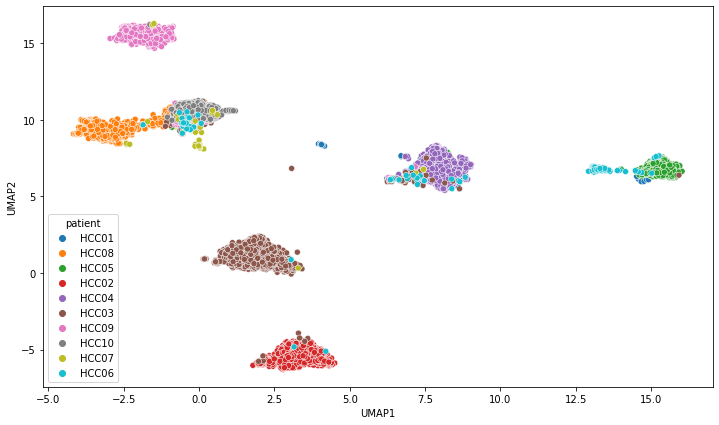

In [23]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=embedding_df,x='UMAP1',y='UMAP2',hue='patient')

In [122]:
from sklearn.cluster import KMeans

x = embedding_df.iloc[:,0:2].to_numpy()
kmeans = KMeans(n_clusters=7, random_state=0).fit(x)
embedding_df['kmeans'] = [str(x) for x in kmeans.labels_]

In [ ]:
html_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/UMAP_transformation/"
fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_result/umap_scatterplot/"
embedding_path = "/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/UMAP_transformation/"
for cell_type in ['hepatocyte','tnk_hepatocyte'] :
    for condition in ['hbv','tumor'] :
        embedding_df = pd.read_csv(embedding_path + "umap_transformation_%s_%s.txt" % (cell_type,condition),sep='\t',index_col=0)
        if condition == 'hbv' :
            n_genes = 1410
        else :
            n_genes = 4328
        #plot section
        fig_title = "UMAP transformation by %s-only voted gene (%d genes)" % (condition,n_genes)
        hue_list = ['cluster','stage','patient','virus']
        if condition == 'hbv' :
            n_genes = 1410
        else :
            n_genes = 4328
        f, axes = plt.subplots(2, 2,figsize=(20,12))

        for idx,axs in enumerate(axes.ravel()) :
            hue = hue_list[idx]
            sns.scatterplot(data=embedding_df,x='UMAP1',y='UMAP2',hue=hue,palette = "Set3",ax=axs)
        plt.suptitle(fig_title, fontsize=16)
        plt.tight_layout()
        plt.savefig(fig_output_path + "umap_transformation_tumor_%s_metadata_subplot_%s.png" % (cell_type,condition),dpi=300,bbox_inches='tight')

In [ ]:
html_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/UMAP_transformation/"
fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_result/cell_summary/"
embedding_path = "/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/UMAP_transformation/"
cell_type = 'hepatocyte'
condition = 'tumor'
for cell_type in ['hepatocyte','tnk_hepatocyte'] :
    for condition in ['hbv','tumor'] :
        embedding_df = pd.read_csv(embedding_path + "umap_transformation_%s_%s.txt" % (cell_type,condition),sep='\t',index_col=0)
        fig = celltype_summary_barplot(embedding_df,x='cluster',hue='stage')
        fig.write_html(html_output_path + "umap_transformation_%s_kmeans_stage_cell_summary_%s.html" % (cell_type,condition))
        fig.write_image(fig_output_path + "umap_transformation_%s_kmeans_stage_cell_summary_%s.png" % (cell_type,condition),scale=2)
        fig.show()

        fig = celltype_summary_barplot(embedding_df,x='cluster',hue='Advance_celltype')
        fig.write_html(html_output_path + "umap_transformation_%s_kmeans_celltype_cell_summary_%s.html" % (cell_type,condition))
        fig.write_image(fig_output_path + "umap_transformation_%s_kmeans_celltype_cell_summary_%s.png" % (cell_type,condition),scale=2)
        fig.show()


### Random sample manifold transfold

In [ ]:
target_x = read_and_transform("/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC_hepatocyte_normalized.pkl")
vote_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/"
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
n_patch = 10

condition = [('tumor_only',25),('hbv_only',35)]
for con in condition :
    exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % con[0],sep='\t',index_col=0)
    gene_idx = list(exp_m.index)
    vote_result = read_vote_result(vote_path,con[0]+ '_std_by_gene',con[1],gene_idx)
    non_voted_genes = list(vote_result.index[np.where(vote_result == 0,True,False)])
    n_voted_genes = sum(np.where(vote_result > 0,1,0))
    for i in range(n_patch) :
        candidate_genes = random.sample(non_voted_genes,n_voted_genes)
        embedding_df = candidate_genes_umap_transformation(target_x,metadata,candidate_genes)
        title = 'UMAP projection of the GSE149614 scRNA dataset of %s non-voted gene (%d non-voted genes)' % (con[0],n_voted_genes)
        manifold_scatterplot(embedding_df,xaxis='UMAP1',yaxis='UMAP2',hue="Stage",title=title,output_path='/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_result/random_sample_manifold_transformation/%s_non_voted_gene_patch_%d.png' % (con[0],i))


### Explode gene mean & variant 

In [2]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC_hepatocyte_normalized.pkl",'rb') as f :
    target_x = pickle.load(f)
f.close()

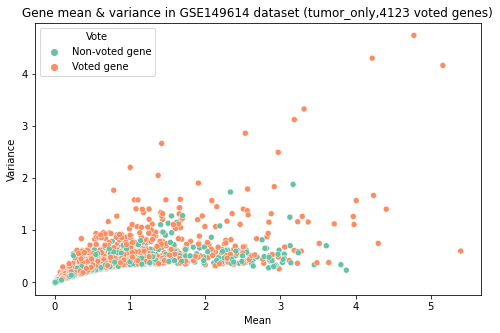

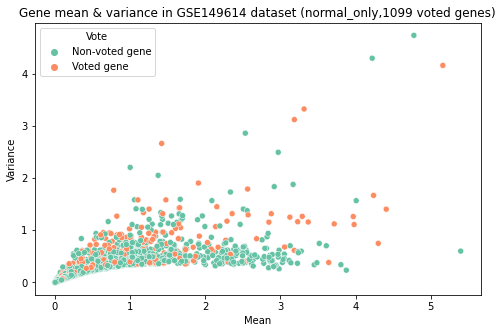

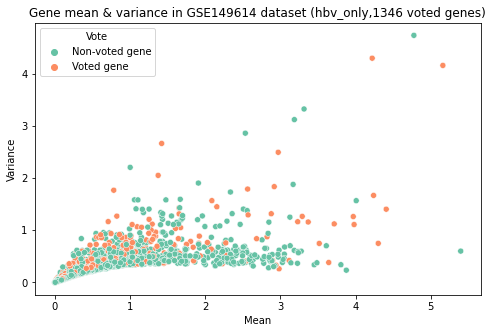

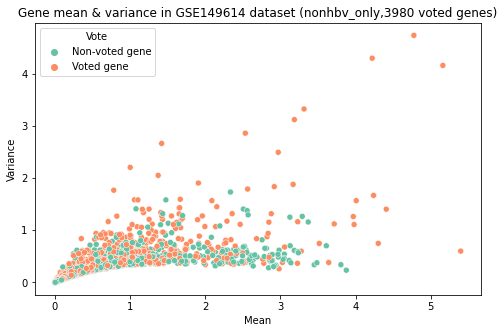

In [7]:
exp_mean = target_x.T.mean()
exp_variance = target_x.T.std()
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_result/scRNA_voted_gene_mean_variance/'
vote_path = "/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/"
condition = [('tumor_only',25),('normal_only',15),('hbv_only',35),('nonhbv_only',20)]
for con in condition :
    exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % con[0],sep='\t',index_col=0)
    gene_idx = list(set(exp_m.index).intersection(target_x.index))
    vote_result = read_vote_result(vote_path,con[0]+ '_std_by_gene',con[1],list(exp_m.index))
    vote_label = np.where(vote_result[gene_idx] > 0 ,'Voted gene','Non-voted gene')
    n_voted_genes = sum(np.where(vote_result[gene_idx] > 0 ,1,0))
    df = pd.DataFrame({'Vote' : vote_label,'Mean' : exp_mean[gene_idx],'Variance' : [x ** 2 for x in exp_variance[gene_idx]]},index=gene_idx)
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df,x='Mean',y='Variance',hue='Vote',palette='Set2')
    plt.title("Gene mean & variance in GSE149614 dataset (%s,%d voted genes)" % (con[0],n_voted_genes))
    plt.savefig(output_path + 'gene_mean_variance_%s.png' % con[0],dpi=300)
    plt.show()

### Identify marker gene from manifold cluster

In [47]:
from scipy.stats import ranksums
from sklearn.cluster import KMeans
from statsmodels.sandbox.stats.multicomp import multipletests

class scRNA() :
    def __init__(self,exp_m,metadata,embedding,n_cluster) :
        self.expression_matrix = exp_m
        self.embedding = embedding
        self.genelist = list(exp_m.columns)
        self.sample = list(exp_m.index)
        self.metadata = metadata
        self.n_cluster = n_cluster
        self.foldchange = [np.zeros(len(self.genelist)) for _ in range(self.n_cluster) ] 
        #self.pvalue = [np.zeros(len(self.genelist)) for _ in range(self.n_cluster) ] 
        self.rejected = [np.zeros(len(self.genelist)) for _ in range(self.n_cluster) ] 
        self.adjusted_pvalue = [np.zeros(len(self.genelist)) for _ in range(self.n_cluster) ] 
        self.market_gene_df = pd.DataFrame()
    '''
    def wilconox(self,condition,target,cluster_idx) :
        if condition not in self.metadata.columns :
            print("Make sure condition information in metadata")
            return
        candidate = self.metadata.index[np.where(self.metadata[condition] == target,True,False)]
        for idx,gene in enumerate(self.genelist) :
            _,pv = ranksums(self.expression_matrix.loc[candidate,gene].values,self.expression_matrix.loc[[x not in candidate for x in self.expression_matrix.index],gene].values)
            self.pvalue[cluster_idx][idx] = float(pv)
    '''
    def kmeans_clustering(self) :
        if 'kmeans' in self.embedding.columns :
            self.metadata['kmeans'] = self.embedding['kmeans']
        else :
            kmeans = KMeans(n_clusters=self.n_cluster, random_state=0).fit(self.embedding.loc[:,["UMAP1","UMAP2"]].to_numpy()) # type: ignore
            label = kmeans.labels_
            self.metadata['kmeans'] = label

    def bonferroni(self,condition,target,cluster_idx) :
        pv_list = []
        candidate = self.metadata.index[np.where(self.metadata[condition] == target,True,False)]
        for gene in self.genelist :
            _,pv = ranksums(self.expression_matrix.loc[candidate,gene].values,self.expression_matrix.loc[[x not in candidate for x in self.expression_matrix.index],gene].values)
            pv_list.append(pv)
        self.rejected[cluster_idx],self.adjusted_pvalue[cluster_idx], _, _ = multipletests(pv_list,alpha=0.05, method='bonferroni', is_sorted=False)

    def fold_change(self,condition,target,cluster_idx) :
        candidate = self.metadata.index[np.where(self.metadata[condition] == target,True,False)]
        for idx,gene in enumerate(self.genelist) :
            candidate_exp = self.expression_matrix.loc[candidate,gene].mean()
            no_candidate_exp = self.expression_matrix.loc[[x not in candidate for x in self.expression_matrix.index],gene].mean()
            if candidate_exp == 0  :
                self.foldchange[cluster_idx][idx] = np.inf
            elif no_candidate_exp == 0 :
                self.foldchange[cluster_idx][idx] = np.nan
            else :
                self.foldchange[cluster_idx][idx] = candidate_exp / no_candidate_exp
    def identify_marker_gene(self) :
        for idx,i in enumerate(self.metadata['kmeans'].unique()) :
            print("Identify marker gene for clsuter %s" % i)
            self.bonferroni('kmeans',i,idx)
            self.fold_change('kmeans',i,idx)
            
    def summarize_result(self) :
        m = np.empty([len(self.genelist),len(self.metadata['kmeans'].unique())],dtype=object)
        for i in range(len(self.metadata['kmeans'].unique())) :
            rejected = self.rejected[i]
            fold_change = self.foldchange[i]
            idx = fold_change > 2
            for g in range(len(self.genelist)) :
                if rejected[g] and idx[g] :
                    m[g,i] = 'Marker gene'
                else :
                    m[g,i] = 'Non marker gene'
        df = pd.DataFrame(m,index=self.genelist,columns=['Cluster_' + str(x) for x in self.metadata['kmeans'].unique()])
        self.market_gene_df = df

In [ ]:
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
idx = np.where((metadata['site'] =='Tumor') & (metadata['Celltype'] =='Hepatocyte'),True,False)
target = metadata.index[idx]
target_metadata = metadata.loc[target,:]
##load expression information
condition = ['hbv_only']
for con in condition :
        embedding_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/GSE149614_scRNA_umap_transformation_%s.txt" % con,sep='\t',index_col=0)
        sub_pickle_path = '/home/bruce1996/nvme2/scRNA/GSE149614_HCC_tumor_hepatocyte_%s.normalized.pickle' % con
        with open(sub_pickle_path,'rb') as f :
                exp_m = pickle.load(f)
        con_scRNA = scRNA(exp_m=exp_m.astype(float),metadata=target_metadata,embedding=embedding_df,n_cluster=6)
        con_scRNA.kmeans_clustering()
        con_scRNA.identify_marker_gene()
        con_scRNA.summarize_result()
        df = con_scRNA.market_gene_df
        df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/marker_gene_list_%s.txt" % con ,sep='\t')
        

In [3]:
def intersection_marker_candidate_gene(module_df,df) :
    overlap_m = np.zeros([module_df.shape[0],df.shape[1]])
    for go_idx,go in enumerate(module_df.index) :
        candidate = module_df.loc[go,'Nodes'].split("_")
        for c_idx,cluster in enumerate(df.columns) :
            marker_gene = df.index[np.where(df[cluster] == 'Marker gene',True,False)]
            overlap_m[go_idx,c_idx] = round(100 * len(set(candidate).intersection(marker_gene)) / len(candidate),2)
    overlap_df = pd.DataFrame(overlap_m,index=module_df.index,columns=df.columns)
    return overlap_df

def intersection_marker_candidate_gene_heatmap(intersect_m,module_df,cluster_df,con,fig_name) :
    m_index = []
    m_col = []
    for go in intersect_m.index :
        n = module_df.loc[go,'#Nodes']
        name = module_df.loc[go,'Description']
        m_index.append("%s (n=%d)" % (name,n))
    for cluster in intersect_m.columns :
        n = sum(np.where(cluster_df[cluster] == 'Marker gene',True,False))
        m_col.append("%s (n=%d)" % (cluster,n))
    
    intersect_m.index = m_index
    intersect_m.columns = m_col

    plt.figure(figsize=(10,7))
    sns.heatmap(intersect_m,annot=True,vmax=100,fmt="0.2f",linewidths=1,cmap='PuBuGn')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title("Overlap between marker genes & functional module candidate genes (%s,%s)" % con)
    plt.savefig(fig_name,dpi=300,bbox_inches='tight')


In [19]:
def intersection_marker_marker_gene(cluster_df) :
    overlap_m = np.zeros([cluster_df.shape[1],cluster_df.shape[1]])
    for c1_idx,c1 in enumerate(cluster_df.columns) :
        marker_gene1 = cluster_df.index[np.where(cluster_df[c1] == 'Marker gene',True,False)]
        if len(marker_gene1) == 0 :
            continue
        for c2_idx,c2 in enumerate(cluster_df.columns) :
            marker_gene = cluster_df.index[np.where(cluster_df[c2] == 'Marker gene',True,False)]
            overlap_m[c1_idx,c2_idx] = round(100 * len(set(marker_gene1).intersection(marker_gene)) / len(marker_gene1),2)
    overlap_df = pd.DataFrame(overlap_m,index=cluster_df.columns,columns=cluster_df.columns)
    return overlap_df

def intersection_marker_marker_gene_heatmap(intersect_m,cluster_df,con,fig_name) :
    m_col = []
    for cluster in intersect_m.columns :
        n = sum(np.where(cluster_df[cluster] == 'Marker gene',True,False))
        m_col.append("%s (n=%d)" % (cluster,n))
    intersect_m.index = m_col
    intersect_m.columns = m_col 
    
    plt.figure(figsize=(10,7))
    sns.heatmap(intersect_m,annot=True,vmax=100,fmt="0.2f",linewidths=1,cmap='PuBuGn')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title("Overlap between marker genes & functional module candidate genes (%s)" % con)
    plt.savefig(fig_name,dpi=300,bbox_inches='tight')


In [ ]:
sheet_list = ['hbv_only_20','nonhbv_only_20','tumor_only_25','normal_only_15']
for ppi_network in ['GRN','PIN'] :
    for sheet in sheet_list :
        con = sheet.split('_')[0]
        module_df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/final_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi_network, sheet_name=sheet,index_col=1)
        cluster_df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/marker_gene_list_%s.txt" % con ,sep='\t',index_col=0)
        fig_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/scRNA_marker_gene/"
        if os.path.exists(fig_path) == False :
            os.mkdir(fig_path)
        fig_name = "%s_%s_funModu_overlap_heatmap.png" % (con,ppi_network)
        m = intersection_marker_candidate_gene(module_df,df)
        intersection_marker_candidate_gene_heatmap(m,module_df,cluster_df,(con,ppi_network),fig_name)
